In [ ]:
import sionna
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

#from sionna.channel import AWGN
from sionna.channel import RayleighBlockFading
from sionna import config
from sionna.utils import BinarySource, ebnodb2no, log10, expand_to_rank, insert_dims
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.utils import sim_ber
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
from tqdm.auto import tqdm
import numpy as np

2025-02-20 15:55:51.844873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 15:55:52.696256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-02-20 15:55:54.504843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 15:55:54.609106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = -2
ebno_db_max = 4

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 1000 #10000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 700 #7000
num_training_iterations_rl_finetuning = 300 #3000
###############################################
# Meta-RL Training configuration
###############################################
num_training_iterations_meta_rl = 500 #1000 # Number of training iterations for Meta-RL training
meta_batch_size = 8 # Number of tasks for each meta-training iteration

training_batch_size = tf.constant(32, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done
model_weights_path_metarl_training = "awgn_autoencoder_weights_metarl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path + "__rf", 'wb') as f:
        pickle.dump(weights, f)

# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(1, tf.constant(10.0, tf.float32))
    with open(model_weights_path + "__rf", 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)

2025-02-20 15:55:54.922041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 15:55:54.923360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-20 15:55:54.924569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
num_tx = 4
num_rx = 16

sionna.config.xla_compat=True
class Baseline(tf.keras.Model):
    def __init__(self, spatial_corr=None):
        super().__init__()
        self.n = n 
        self.k = k  
        self.coderate = coderate
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_tx_ant = num_tx
        self.num_rx_ant = num_rx
        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        b = self.binary_source([batch_size, self.num_tx_ant, self.k])
        c = self.encoder(b)
        
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        # print(ebno_db)
        # print(no, no.shape)
        no *= np.sqrt(self.num_rx_ant)

        y, h = self.channel([x, no])
        # print(no, no.shape)
        # print(self.num_rx_ant)
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)
        
        llr = self.demapper([x_hat, no_eff])
        b_hat = self.decoder(llr)
        
        return b,  b_hat

XLA can lead to reduced numerical precision. Use with care.


In [4]:
class NeuralDemapper(Model):

    def __init__(self):
        super().__init__()

        self._dense_1 = Dense(128, 'relu')
        self._dense_2 = Dense(256, 'relu')
        self._dense_3 = Dense(128, 'relu')
        self._dense_4 = Dense(num_bits_per_symbol, None) # The feature correspond to the LLRs for every bits carried by a symbol

    @tf.function(jit_compile=True)
    def call(self, inputs):
        y,no = inputs

        # Using log10 scale helps with the performance
        no_db = log10(no)

        # Stacking the real and imaginary components of the complex received samples
        # and the noise variance
        # no_db = tf.tile(no_db, [1, num_symbols_per_codeword]) # [batch size, num_symbols_per_codeword]
        y = tf.reshape(y, [1, -1])
        no_db = tf.reshape(no_db, [1, -1])
        
        z = tf.stack([tf.math.real(y),
                      tf.math.imag(y),
                      no_db,
                      ], axis=2) # [batch size, num_symbols_per_codeword, 3]
        llr = self._dense_1(z)
        llr = self._dense_2(llr)
        llr = self._dense_3(llr)
        llr = self._dense_4(llr) # [batch size, num_symbols_per_codeword, num_bits_per_symbol]

        return llr

In [5]:
class E2ESystemConventionalTraining(tf.keras.Model):
    def __init__(self, training, spatial_corr=None):
        super().__init__()
        self.training = training

        self.n = n 
        self.k = k  
        self.coderate = coderate
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_tx_ant = num_tx
        self.num_rx_ant = num_rx
        self.binary_source = BinarySource()
        if not self.training:
            self.encoder = LDPC5GEncoder(k, n, num_bits_per_symbol) 
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self.mapper = Mapper(constellation=constellation)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        self.demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self.training:
            self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
            
        #################
        # Loss function
        #################
        if self.training:
            self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        if self.training:
            c = self.binary_source([batch_size, self.num_tx_ant, self.n])
        else:
            b = self.binary_source([batch_size, self.num_tx_ant, self.k])
            c = self.encoder(b)
            
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)
        
        y, h = self.channel([x, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)
        
        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        llr = tf.reshape(llr, [batch_size, self.num_tx_ant, self.n])
        # If training, outer decoding is not performed and the BCE is returned
        if self.training:
            loss = self.bce(c, llr)
            return loss
        else:
            # Outer decoding
            b_hat = self.decoder(llr)
            return b, b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()
    for i in tqdm(pbar := tqdm(range(num_training_iterations_conventional))):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        for no in ebno_db:
            with tf.GradientTape() as tape:
                loss = model(training_batch_size, no) # The model is assumed to return the BMD rate
            # Computing and applying gradients
            weights = model.trainable_weights
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))
        # Printing periodically the progress
        txt = f"BCE: {loss.numpy()}"
        pbar.set_description(txt)
        # if i % 100 == 0:
        #     print('Iteration {}/{}  BCE: {:.4f}'.format(i, num_training_iterations_conventional, loss.numpy()), end='\r')

In [6]:
# Fix the seed for reproducible trainings
tf.random.set_seed(1)
# Instantiate and train the end-to-end system
model = E2ESystemConventionalTraining(training=True)
conventional_training(model)
# Save weights
save_weights(model, model_weights_path_conventional_training)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-20 15:56:02.130274: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46d16f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-20 15:56:02.130297: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-02-20 15:56:02.169295: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mapper/assert_greater_equal/Assert/Assert
2025-02-20 15:56:02.169331: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator flat_fading_channel/apply_flat_fading_channel/awgn/assert_greater_equal/Assert/Assert
2025-02-20 15:56:02.169346: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator flat_fading_channel/apply_flat_fading_channel/awgn/assert_less_equal/Assert/Assert
2025-02-20 15:56:02.169363: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator flat_fading

In [7]:
class E2ESystemRLTraining(tf.keras.Model):
    def __init__(self, training, spatial_corr=None):
        super().__init__()
        self.training = training

        self.n = n 
        self.k = k  
        self.coderate = coderate
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_tx_ant = num_tx
        self.num_rx_ant = num_rx
        self.binary_source = BinarySource()
        if not self.training:
            self.encoder = LDPC5GEncoder(k, n, num_bits_per_symbol) 
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self.mapper = Mapper(constellation=constellation)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        self.demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self.training:
            self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
            
        #################
        # Loss function
        #################
        if self.training:
            self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
     
    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):
        if self.training:
            c = self.binary_source([batch_size, self.num_tx_ant, self.n])
        else:
            b = self.binary_source([batch_size, self.num_tx_ant, self.k])
            c = self.encoder(b)
            
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        epsilon_r = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon_i = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon = tf.complex(epsilon_r, epsilon_i) # [batch size, num_symbols_per_codeword]
        x_p = x + epsilon

        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)
        
        y, h = self.channel([x_p, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)

        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        # If training, outer decoding is not performed and the BCE is returned
        if self.training:
            c = tf.reshape(c, [-1, num_symbols_per_codeword * self.num_tx_ant, num_bits_per_symbol])
            llr = tf.reshape(llr, [-1, num_symbols_per_codeword * self.num_tx_ant, num_bits_per_symbol])
            bce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(c, llr), axis=2) # Avergare over the bits mapped to a same baseband symbol
            # The RX loss is the usual average BCE
            rx_loss = tf.reduce_mean(bce)
            # From the TX side, the BCE is seen as a feedback from the RX through which backpropagation is not possible
            bce = tf.stop_gradient(bce) # [batch size, num_symbols_per_codeword]
            x_p = tf.stop_gradient(x_p)
            p = x_p-x # [batch size, num_symbols_per_codeword] Gradient is backpropagated through `x`
            p = tf.reshape(p, bce.shape)
            tx_loss = tf.square(tf.math.real(p)) + tf.square(tf.math.imag(p)) # [batch size, num_symbols_per_codeword]
            tx_loss = -bce*tx_loss/rl_perturbation_var # [batch size, num_symbols_per_codeword]
            tx_loss = tf.reduce_mean(tx_loss)
            return tx_loss, rx_loss
        else:
            # Outer decoding
            llr = tf.reshape(llr, [batch_size, self.num_tx_ant, self.n])
            b_hat = self.decoder(llr)
            return b, b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

def rl_based_training(model):
    # Optimizers used to apply gradients
    optimizer_tx = tf.keras.optimizers.Adam() # For training the transmitter
    optimizer_rx = tf.keras.optimizers.Adam() # For training the receiver

    # Function that implements one transmitter training iteration using RL.
    @tf.function
    def train_tx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[4], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        for no in ebno_db:
            with tf.GradientTape() as tape:
                # Keep only the TX loss
                tx_loss, _ = model(4, no,
                                   tf.constant(rl_perturbation_var, tf.float32)) # Perturbation are added to enable RL exploration
            ## Computing and applying gradients
            weights = model.trainable_weights
            grads = tape.gradient(tx_loss, weights)
            optimizer_tx.apply_gradients(zip(grads, weights))
    
    # Function that implements one receiver training iteration
    @tf.function
    def train_rx():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[4], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        for no in ebno_db:
            with tf.GradientTape() as tape:
                # Keep only the RX loss
                _, rx_loss = model(4, no) # No perturbation is added
            ## Computing and applying gradients
            weights = model.trainable_weights
            grads = tape.gradient(rx_loss, weights)
            optimizer_rx.apply_gradients(zip(grads, weights))
    
    # Training loop.
    for i in tqdm(pbar := tqdm(range(num_training_iterations_rl_alt))):
        # 10 steps of receiver training are performed to keep it ahead of the transmitter
        # as it is used for computing the losses when training the transmitter
        for _ in range(10):
            train_rx()
        # One step of transmitter training
        # train_tx()     
        # get progress training
        ebno_db = tf.random.uniform(shape=[3], minval=ebno_db_min, maxval=ebno_db_max)
        with tf.GradientTape() as tape:
            _, rx_loss = model(4, ebno_db[1])
        # Printing periodically the progress
        txt = f"BCE: {rx_loss.numpy()}"
        pbar.set_description(txt)
    
    # Once alternating training is done, the receiver is fine-tuned.
    print('Receiver fine-tuning... ')
    for i in tqdm(pbar := tqdm(range(num_training_iterations_rl_finetuning))):
        train_rx()

In [8]:
# Fix the seed for reproducible trainings
tf.random.set_seed(1)
# Instantiate and train the end-to-end system
model = E2ESystemRLTraining(training=True)
rl_based_training(model)
# Save weights
save_weights(model, model_weights_path_rl_training)

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

2025-02-20 16:01:17.632790: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x44824bf0


Receiver fine-tuning... 


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
class E2ESystemMetaRLTraining(tf.keras.Model):
    def __init__(self, training, spatial_corr=None):
        super().__init__()
        self.training = training

        self.n = n 
        self.k = k  
        self.coderate = coderate
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_tx_ant = num_tx
        self.num_rx_ant = num_rx
        self.binary_source = BinarySource()
        if not self.training:
            self.encoder = LDPC5GEncoder(k, n, num_bits_per_symbol) 
        # Trainable constellation
        constellation = Constellation("qam", num_bits_per_symbol, trainable=True)
        self.constellation = constellation
        self.mapper = Mapper(constellation=constellation)
        self.channel = FlatFadingChannel(self.num_tx_ant,
                                         self.num_rx_ant,
                                         spatial_corr=spatial_corr,
                                         add_awgn=True,
                                         return_channel=True)
        self.demapper = NeuralDemapper()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not self.training:
            self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)
            
        #################
        # Loss function
        #################
        if self.training:
            self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
     
    def call(self, batch_size, ebno_db, perturbation_variance=tf.constant(0.0, tf.float32)):
        if self.training:
            c = self.binary_source([batch_size, self.num_tx_ant, self.n])
        else:
            b = self.binary_source([batch_size, self.num_tx_ant, self.k])
            c = self.encoder(b)
            
        x = self.mapper(c)
        shape = tf.shape(x)
        x = tf.reshape(x, [-1, self.num_tx_ant])
        
        epsilon_r = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon_i = tf.random.normal(tf.shape(x))*tf.sqrt(0.5*perturbation_variance)
        epsilon = tf.complex(epsilon_r, epsilon_i) # [batch size, num_symbols_per_codeword]
        x_p = x + epsilon

        
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        no *= np.sqrt(self.num_rx_ant)
        
        y, h = self.channel([x_p, no])
        s = tf.complex(no*tf.eye(self.num_rx_ant, self.num_rx_ant), 0.0)
        
        x_hat, no_eff = lmmse_equalizer(y, h, s)

        x_hat = tf.reshape(x_hat, shape)
        no_eff = tf.reshape(no_eff, shape)

        llr = self.demapper([x_hat, no_eff])
        # If training, outer decoding is not performed and the BCE is returned
        if self.training:
            c = tf.reshape(c, [-1, num_symbols_per_codeword * self.num_tx_ant, num_bits_per_symbol])
            llr = tf.reshape(llr, [-1, num_symbols_per_codeword * self.num_tx_ant, num_bits_per_symbol])
            bce = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(c, llr), axis=2) # Avergare over the bits mapped to a same baseband symbol
            # The RX loss is the usual average BCE
            rx_loss = tf.reduce_mean(bce)
            # From the TX side, the BCE is seen as a feedback from the RX through which backpropagation is not possible
            bce = tf.stop_gradient(bce) # [batch size, num_symbols_per_codeword]
            x_p = tf.stop_gradient(x_p)
            p = x_p-x # [batch size, num_symbols_per_codeword] Gradient is backpropagated through `x`
            p = tf.reshape(p, bce.shape)
            tx_loss = tf.square(tf.math.real(p)) + tf.square(tf.math.imag(p)) # [batch size, num_symbols_per_codeword]
            tx_loss = -bce*tx_loss/rl_perturbation_var # [batch size, num_symbols_per_codeword]
            tx_loss = tf.reduce_mean(tx_loss)
            return tx_loss, rx_loss
        else:
            # Outer decoding
            llr = tf.reshape(llr, [batch_size, self.num_tx_ant, self.n])
            b_hat = self.decoder(llr)
            return b, b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation


def copy_model(model):
    adapted_model = tf.keras.models.clone_model(model)
    adapted_model(1, tf.constant(10.0, tf.float32))
    adapted_model.set_weights(model.get_weights())
    return adapted_model

def inner_train(model, task_snr_values, inner_interations = 3):
    # return grads & avg loss
    def get_avg_grads(grads):
        _grads = []
        for j in range(len(grads[0])):
            __grads = []
            for x in grads:
                __grads.append(x[j])
            __grads = tf.math.reduce_mean(__grads, axis=0)
            _grads.append(
                tf.Variable(__grads)
            )
        return _grads
            
    inner_loss = []
    tx_grad = []
    rx_grad = []
    
    adapted_model = copy_model(model)
    for _ in range(inner_interations): 
        for snr in task_snr_values:
            with tf.GradientTape() as tx_tape:
                _, rx_loss = adapted_model(4, snr)
            weights = adapted_model.demapper.trainable_variables
            grads = tx_tape.gradient(rx_loss, weights)
            rx_grad.append(grads)    
        
            inner_loss.append(rx_loss.numpy())
            
            with tf.GradientTape() as rx_tape:
                tx_loss, _ = adapted_model(4, snr, tf.constant(rl_perturbation_var))
            weights = adapted_model.constellation.trainable_variables
            grads = rx_tape.gradient(tx_loss, weights)
            tx_grad.append(grads)    
        
    return np.mean(inner_loss), get_avg_grads(tx_grad), get_avg_grads(rx_grad) 

def meta_rl_training(model):
    lr_outer = 0.01
    # Meta-training loop
    num_training_iterations_meta_rl = 1000
    for i in tqdm(pbar := tqdm(range(num_training_iterations_meta_rl))):
        optimizer_constellation = tf.keras.optimizers.Adam()
        optimizer_demapper = tf.keras.optimizers.Adam()
        fixed_snr = ebno_db_max
        task_snr_values = tf.random.uniform([8], minval=ebno_db_min, maxval=ebno_db_max)  
        
        inner_loss, tx_grad, rx_grads = inner_train(model, task_snr_values)
        weights = model.demapper.trimport os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time

from sionna.phy import Block
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, \
                            OFDMModulator, OFDMDemodulator, RZFPrecoder, RemoveNulledSubcarriers
from sionna.phy.channel.tr38901 import AntennaArray, CDL
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, \
                               time_lag_discrete_time_channel, ApplyOFDMChannel, ApplyTimeChannel, \
                               OFDMChannel, TimeChannel
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, BinarySource
from sionna.phy.utils import ebnodb2no, sim_ber, compute_ber
from tqdm import tqdm
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0
###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
num_symbols_per_codeword = n//num_bits_per_symbol # Number of modulated baseband symbols per codeword
k = int(n*coderate) # Number of information bits per codeword

###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 200000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 7000
num_training_iterations_rl_finetuning = 3000
training_batch_size = tf.constant(32, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation
#  configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

class NeuralDemapper(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # Increase network capacity to handle complex demapping
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(512, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1440)  # Match codeword length
        
    def call(self, x_hat, no_eff):
        # Extract real and imaginary parts of the complex tensor
        x_hat_real = tf.math.real(x_hat)
        x_hat_imag = tf.math.imag(x_hat)
        
        # Concatenate real part, imaginary part, and noise variance
        inputs = tf.concat([x_hat_real, x_hat_imag, no_eff], axis=-1)
        
        # Process through neural network
        x = self.dense1(inputs)
        x = self.dense2(x)
        llr = self.output_layer(x)
        return llr  # Shape will now be [batch_size, 1, 4, 1440]
    
import tensorflow as tf
def build_neural_demapper_functional(): 
    x_hat_input = tf.keras.layers.Input(shape=(72,), dtype=tf.complex64, name="x_hat_input")
    no_eff_input = tf.keras.layers.Input(shape=(72,), dtype=tf.float32, name="no_eff_input")
    demapper_layer = NeuralDemapper()

    # 3) 'Call' the layer on the inputs. 
    #    Note that custom Layer expects (x_hat, no_eff) as separate args.
    llr_output = demapper_layer(x_hat_input, no_eff_input)

    # 4) Build the model by specifying the inputs and outputs.
    model = tf.keras.Model(inputs=[x_hat_input, no_eff_input],
                        outputs=llr_output,
                        name="NeuralDemapperModel")
    return model

class NeuralModel(Block):
    """This block simulates OFDM MIMO transmissions over the CDL model.

    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.

    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.

    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.

    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.

    delay_spread : float
        The nominal delay spread [s].

    perfect_csi : bool
        Indicates if perfect CSI at the receiver should be assumed. For downlink
        transmissions, the transmitter is always assumed to have perfect CSI.

    speed : float
        The UT speed [m/s].

    cyclic_prefix_length : int
        The length of the cyclic prefix in number of samples.

    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.

    subcarrier_spacing : float
        The subcarrier spacing [Hz]. Defaults to 15e3.

    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.

    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.

    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.

    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.
    """

    def __init__(self,
                 domain,
                 direction,
                 cdl_model,
                 delay_spread,
                 perfect_csi,
                 speed,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 15e3,
                 training = True
                ):
        super().__init__()

        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._training = training

        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 8 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2
        self._coderate = 0.5

        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)

        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate)

        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)

        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)

        if self._domain == "freq":
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)

        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        if self._direction == "downlink":
            self._zf_precoder = RZFPrecoder(self._rg, self._sm, return_effective_channel=True)

        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = NeuralDemapper()
        if not self._training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)      
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)
        
    @tf.function # Run in graph mode. See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        if self._training:
            c = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._n])
        else:
            b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
            c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        if self._domain == "time":
            # Time-domain simulations

            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)

            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            x_time = self._modulator(x_rg)
            y_time = self._channel_time(x_time, h_time, no)

            y = self._demodulator(y_time)

        elif self._domain == "freq":
            # Frequency-domain simulations

            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            y = self._channel_freq(x_rg, h_freq, no)

        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est (y, no)

        x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no)
        llr = self._demapper(x_hat, no_eff)
        print(f"The shape of ground truth (C) is {c.shape}")
        llr_reshaped = tf.reshape(llr, [tf.shape(llr)[0], 1, 4, 1440])
        if self._training:
            loss = self._bce(c, llr_reshaped)
            return loss
        else:
            # Outer decoding
            b_hat = self._decoder(llr_reshaped)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation


class Model(Block):
    """This block simulates OFDM MIMO transmissions over the CDL model.

    Simulates point-to-point transmissions between a UT and a BS.
    Uplink and downlink transmissions can be realized with either perfect CSI
    or channel estimation. ZF Precoding for downlink transmissions is assumed.
    The receiver (in both uplink and downlink) applies LS channel estimation
    and LMMSE MIMO equalization. A 5G LDPC code as well as QAM modulation are
    used.

    Parameters
    ----------
    domain : One of ["time", "freq"], str
        Determines if the channel is modeled in the time or frequency domain.
        Time-domain simulations are generally slower and consume more memory.
        They allow modeling of inter-symbol interference and channel changes
        during the duration of an OFDM symbol.

    direction : One of ["uplink", "downlink"], str
        For "uplink", the UT transmits. For "downlink" the BS transmits.

    cdl_model : One of ["A", "B", "C", "D", "E"], str
        The CDL model to use. Note that "D" and "E" are LOS models that are
        not well suited for the transmissions of multiple streams.

    delay_spread : float
        The nominal delay spread [s].

    perfect_csi : bool
        Indicates if perfect CSI at the receiver should be assumed. For downlink
        transmissions, the transmitter is always assumed to have perfect CSI.

    speed : float
        The UT speed [m/s].

    cyclic_prefix_length : int
        The length of the cyclic prefix in number of samples.

    pilot_ofdm_symbol_indices : list, int
        List of integers defining the OFDM symbol indices that are reserved
        for pilots.

    subcarrier_spacing : float
        The subcarrier spacing [Hz]. Defaults to 15e3.

    Input
    -----
    batch_size : int
        The batch size, i.e., the number of independent Mote Carlo simulations
        to be performed at once. The larger this number, the larger the memory
        requiremens.

    ebno_db : float
        The Eb/No [dB]. This value is converted to an equivalent noise power
        by taking the modulation order, coderate, pilot and OFDM-related
        overheads into account.

    Output
    ------
    b : [batch_size, 1, num_streams, k], tf.float32
        The tensor of transmitted information bits for each stream.

    b_hat : [batch_size, 1, num_streams, k], tf.float32
        The tensor of received information bits for each stream.
    """

    def __init__(self,
                 domain,
                 direction,
                 cdl_model,
                 delay_spread,
                 perfect_csi,
                 speed,
                 cyclic_prefix_length,
                 pilot_ofdm_symbol_indices,
                 subcarrier_spacing = 15e3
                ):
        super().__init__()

        # Provided parameters
        self._domain = domain
        self._direction = direction
        self._cdl_model = cdl_model
        self._delay_spread = delay_spread
        self._perfect_csi = perfect_csi
        self._speed = speed
        self._cyclic_prefix_length = cyclic_prefix_length
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices

        # System parameters
        self._carrier_frequency = 2.6e9
        self._subcarrier_spacing = subcarrier_spacing
        self._fft_size = 72
        self._num_ofdm_symbols = 14
        self._num_ut_ant = 4 # Must be a multiple of two as dual-polarized antennas are used
        self._num_bs_ant = 8 # Must be a multiple of two as dual-polarized antennas are used
        self._num_streams_per_tx = self._num_ut_ant
        self._dc_null = True
        self._num_guard_carriers = [5, 6]
        self._pilot_pattern = "kronecker"
        self._pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices
        self._num_bits_per_symbol = 2
        self._coderate = 0.5

        # Required system components
        self._sm = StreamManagement(np.array([[1]]), self._num_streams_per_tx)

        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing = self._subcarrier_spacing,
                                num_tx=1,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                num_guard_carriers=self._num_guard_carriers,
                                dc_null=self._dc_null,
                                pilot_pattern=self._pilot_pattern,
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        self._n = int(self._rg.num_data_symbols * self._num_bits_per_symbol)
        self._k = int(self._n * self._coderate)

        self._ut_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_ut_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        self._cdl = CDL(model=self._cdl_model,
                        delay_spread=self._delay_spread,
                        carrier_frequency=self._carrier_frequency,
                        ut_array=self._ut_array,
                        bs_array=self._bs_array,
                        direction=self._direction,
                        min_speed=self._speed)

        self._frequencies = subcarrier_frequencies(self._rg.fft_size, self._rg.subcarrier_spacing)

        if self._domain == "freq":
            self._channel_freq = ApplyOFDMChannel(add_awgn=True)

        elif self._domain == "time":
            self._l_min, self._l_max = time_lag_discrete_time_channel(self._rg.bandwidth)
            self._l_tot = self._l_max - self._l_min + 1
            self._channel_time = ApplyTimeChannel(self._rg.num_time_samples,
                                                  l_tot=self._l_tot,
                                                  add_awgn=True)
            self._modulator = OFDMModulator(self._cyclic_prefix_length)
            self._demodulator = OFDMDemodulator(self._fft_size, self._l_min, self._cyclic_prefix_length)

        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        if self._direction == "downlink":
            self._zf_precoder = RZFPrecoder(self._rg, self._sm, return_effective_channel=True)

        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
        self._remove_nulled_scs = RemoveNulledSubcarriers(self._rg)

    @tf.function # Run in graph mode. See the following guide: https://www.tensorflow.org/guide/function
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, 1, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        if self._domain == "time":
            # Time-domain simulations

            a, tau = self._cdl(batch_size, self._rg.num_time_samples+self._l_tot-1, self._rg.bandwidth)
            h_time = cir_to_time_channel(self._rg.bandwidth, a, tau,
                                         l_min=self._l_min, l_max=self._l_max, normalize=True)

            # As precoding is done in the frequency domain, we need to downsample
            # the path gains `a` to the OFDM symbol rate prior to converting the CIR
            # to the channel frequency response.
            a_freq = a[...,self._rg.cyclic_prefix_length:-1:(self._rg.fft_size+self._rg.cyclic_prefix_length)]
            a_freq = a_freq[...,:self._rg.num_ofdm_symbols]
            h_freq = cir_to_ofdm_channel(self._frequencies, a_freq, tau, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            x_time = self._modulator(x_rg)
            y_time = self._channel_time(x_time, h_time, no)

            y = self._demodulator(y_time)

        elif self._domain == "freq":
            # Frequency-domain simulations

            cir = self._cdl(batch_size, self._rg.num_ofdm_symbols, 1/self._rg.ofdm_symbol_duration)
            h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)

            if self._direction == "downlink":
                x_rg, g = self._zf_precoder(x_rg, h_freq)

            y = self._channel_freq(x_rg, h_freq, no)

        if self._perfect_csi:
            if self._direction == "uplink":
                h_hat = self._remove_nulled_scs(h_freq)
            elif self._direction =="downlink":
                h_hat = g
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est (y, no)

        x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no)
        llr = self._demapper(x_hat, no_eff)
        b_hat = self._decoder(llr)

        return b, b_hat

UL_SIMS = {
    "ebno_db" : list(np.arange(-5, 20, 4.0)),
    "cdl_model" : ["A", "B", "C", "D", "E"],
    "delay_spread" : 100e-9,
    "domain" : "freq",
    "direction" : "uplink",
    "perfect_csi" : False,
    "speed" : 0.0,
    "cyclic_prefix_length" : 6,
    "pilot_ofdm_symbol_indices" : [2, 11],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

# filepath: [MIMO_OFDM.py](http://_vscodecontentref_/1)
# … your entire file up to the UL_SIMS dict …

# Remove everything after the UL_SIMS definition
# and replace with the following:

# Change this flag to True when you want to train the NeuralModel
if __name__ == "__main__":
    training = True  # Change to True to train your own model
    if training:
        # Instantiate in training mode (pick any one CDL model during training)
        model = NeuralModel(domain=UL_SIMS["domain"],
                            direction=UL_SIMS["direction"],
                            cdl_model=UL_SIMS["cdl_model"][0],
                            delay_spread=UL_SIMS["delay_spread"],
                            perfect_csi=UL_SIMS["perfect_csi"],
                            speed=UL_SIMS["speed"],
                            cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                            pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"],
                            training=True)

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

        # Conventional training loop
        for i in tqdm(range(num_training_iterations_conventional)):
                ebno_db = tf.random.uniform([], ebno_db_min, ebno_db_max)
                with tf.GradientTape() as tape:
                    # Forward
                    loss = model(training_batch_size, ebno_db)
                # ↓ collect exactly the vars that were used in the forward pass
                weights = tape.watched_variables()
                grads   = tape.gradient(loss, weights)
                optimizer.apply_gradients(zip(grads, weights))

                if i % 100 == 0:
                    print(f"Iteration {i}/{num_training_iterations_conventional}  Loss: {loss.numpy():.4f}", end="\r")

        # Save just the demapper weights
        demapper_weights = model._demapper.get_weights()
        with open(model_weights_path_conventional_training, 'wb') as f:
            pickle.dump(demapper_weights, f)

    else:
        # 1) Evaluation: sweep over all CDL models and Eb/No points
        for cdl in UL_SIMS["cdl_model"]:
            model = NeuralModel(domain=UL_SIMS["domain"],
                                direction=UL_SIMS["direction"],
                                cdl_model=cdl,
                                delay_spread=UL_SIMS["delay_spread"],
                                perfect_csi=UL_SIMS["perfect_csi"],
                                speed=UL_SIMS["speed"],
                                cyclic_prefix_length=UL_SIMS["cyclic_prefix_length"],
                                pilot_ofdm_symbol_indices=UL_SIMS["pilot_ofdm_symbol_indices"],
                                training=False)
            for ebno_db in UL_SIMS["ebno_db"]:
                b, b_hat = model(training_batch_size, ebno_db)
                ber = compute_ber(b, b_hat)
                UL_SIMS["ber"].append(ber)
                print(f"CDL {cdl} | Eb/No {ebno_db:.1f} dB → BER {ber:.3e}")

        # 2) Save results
        with open(results_filename + ".pkl", 'wb') as f:
            pickle.dump(UL_SIMS, f)
        print("Evaluation done, results saved to", results_filename + ".pkl")ainable_variables  
        optimizer_demapper.apply_gradients(zip(rx_grads, weights))
        # weights = model.constellation.trainable_variables  
        # optimizer_constellation.apply_gradients(zip(tx_grad, weights))
        
        # manually update, due to not able to use the optimizer directly
        # model.constellation.set_weights(
        #     tf.subtract(model.constellation.weights, tf.multiply(lr_outer, tx_grad[0])),
        # )
        # k = 0
        # for j in range(len(model.demapper.layers)):
        #     model.demapper.layers[j].set_weights([
        #         tf.subtract(model.demapper.layers[j].kernel, tf.multiply(lr_outer, rx_grads[k])),
        #         tf.subtract(model.demapper.layers[j].bias, tf.multiply(lr_outer, rx_grads[k+1])),
        #     ])
        #     k += 2
            
        # for the outerloop, train with variety of SNRs, but very few data
        task_snr_values = tf.random.uniform([4], minval=ebno_db_max, maxval=ebno_db_max) 
        for snr in task_snr_values:
            # with tf.GradientTape() as tx_tape:
            #     tx_loss, _ = model(4, snr, tf.constant(rl_perturbation_var))
            # weights = model.constellation.trainable_variables  
            # grads = tx_tape.gradient(tx_loss, weights)
            # optimizer_constellation.apply_gradients(zip(grads, weights))  
    
            with tf.GradientTape() as rx_tape:
                _, rx_loss = model(4, snr)
            weights = model.demapper.trainable_variables  
            grads = rx_tape.gradient(rx_loss, weights)
            optimizer_demapper.apply_gradients(zip(grads, weights))
        
        # txt = f"Inner BCE: {inner_loss} || Tx BCE: {tx_loss.numpy()} - Rx BCE: {rx_loss.numpy()}"
        txt = f"Avg BCE: {inner_loss}"

        pbar.set_description(txt)
        
        if (i%50)==0:
            print(f"Epoch {i}:\t" + txt)
            save_weights(meta_model, model_weights_path_metarl_training)
        # break
    print("Meta-RL Training complete.")

# Now, use the modified code in place of the original RL-based training
tf.random.set_seed(1)
# init model
meta_model = E2ESystemMetaRLTraining(training=True)
meta_model(1, tf.Variable(5.0))
# load pre-trained model before -- you can use this to continously train the model if the memory capacity is not enough # Previous total iterations = 1k
# load_weights(meta_model, model_weights_path_metarl_training) 
# train meta-model
meta_rl_training(meta_model)
save_weights(meta_model, model_weights_path_metarl_training)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0:	Avg BCE: 0.6916242241859436
Epoch 50:	Avg BCE: 0.3577195107936859
Epoch 100:	Avg BCE: 0.3278932273387909
Epoch 150:	Avg BCE: 0.3267006278038025
Epoch 200:	Avg BCE: 0.33965829014778137
Epoch 250:	Avg BCE: 0.2964220941066742
Epoch 300:	Avg BCE: 0.31595709919929504
Epoch 350:	Avg BCE: 0.23813527822494507
Epoch 400:	Avg BCE: 0.3022439181804657
Epoch 450:	Avg BCE: 0.3061107099056244
Epoch 500:	Avg BCE: 0.3032619059085846
Epoch 550:	Avg BCE: 0.30865752696990967
Epoch 600:	Avg BCE: 0.2663230001926422
Epoch 650:	Avg BCE: 0.3092104494571686
Epoch 700:	Avg BCE: 0.33648931980133057
Epoch 750:	Avg BCE: 0.3237856328487396
Epoch 800:	Avg BCE: 0.2681218385696411
Epoch 850:	Avg BCE: 0.3038009703159332
Epoch 900:	Avg BCE: 0.3411008417606354
Epoch 950:	Avg BCE: 0.28067439794540405
Meta-RL Training complete.


In [12]:
# BLER = {}
# BER = {}

# # Range of SNRs over which the systems are evaluated
# ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
#                      ebno_db_max, # Max SNR for evaluation
#                      0.5) # Step

# model_metarl = E2ESystemMetaRLTraining(training=False)
# load_weights(model_metarl, model_weights_path_metarl_training)
# ber,bler = sim_ber(model_metarl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
# BLER['autoencoder-metarl'] = bler.numpy()
# BER['autoencoder-metarl'] = ber.numpy()

In [14]:
# Dictionnary storing the results
# with open('base_result', 'rb') as f:
#     BLER = pickle.load(f)

BLER = {}
BER = {}

# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

model_baseline = Baseline()
ber,bler = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['baseline'] = bler.numpy()
BER['baseline'] = ber.numpy()


model_conventional = E2ESystemConventionalTraining(training=False)
load_weights(model_conventional, model_weights_path_conventional_training)
ber,bler = sim_ber(model_conventional, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-conv'] = bler.numpy()
BER['autoencoder-conv'] = ber.numpy()

model_rl = E2ESystemRLTraining(training=False)
load_weights(model_rl, model_weights_path_rl_training)
ber,bler = sim_ber(model_rl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-rl'] = bler.numpy()
BER['autoencoder-rl'] = ber.numpy()

model_metarl = E2ESystemMetaRLTraining(training=False)
load_weights(model_metarl, model_weights_path_metarl_training)
ber,bler = sim_ber(model_metarl, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000)
BLER['autoencoder-metarl'] = bler.numpy()
BER['autoencoder-metarl'] = ber.numpy()

with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BLER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -2.0 | 1.5356e-01 | 1.0000e+00 |      117936 |      768000 |         1024 |        1024 |         1.4 |reached target block errors
     -1.5 | 1.3982e-01 | 1.0000e+00 |      107378 |      768000 |         1024 |        1024 |         1.4 |reached target block errors
     -1.0 | 1.1937e-01 | 1.0000e+00 |       91680 |      768000 |         1024 |        1024 |         1.2 |reached target block errors
     -0.5 | 9.3990e-02 | 9.9121e-01 |       72184 |      768000 |         1015 |        1024 |         1.2 |reached target block errors
      0.0 | 5.7554e-02 | 8.6849e-01 |       66302 |     1152000 |         1334 |        1536 |         1.8 |reached target block errors
      0.5 | 1.9026e-02 | 4.8281e-01 |       36530 |     1920000 |

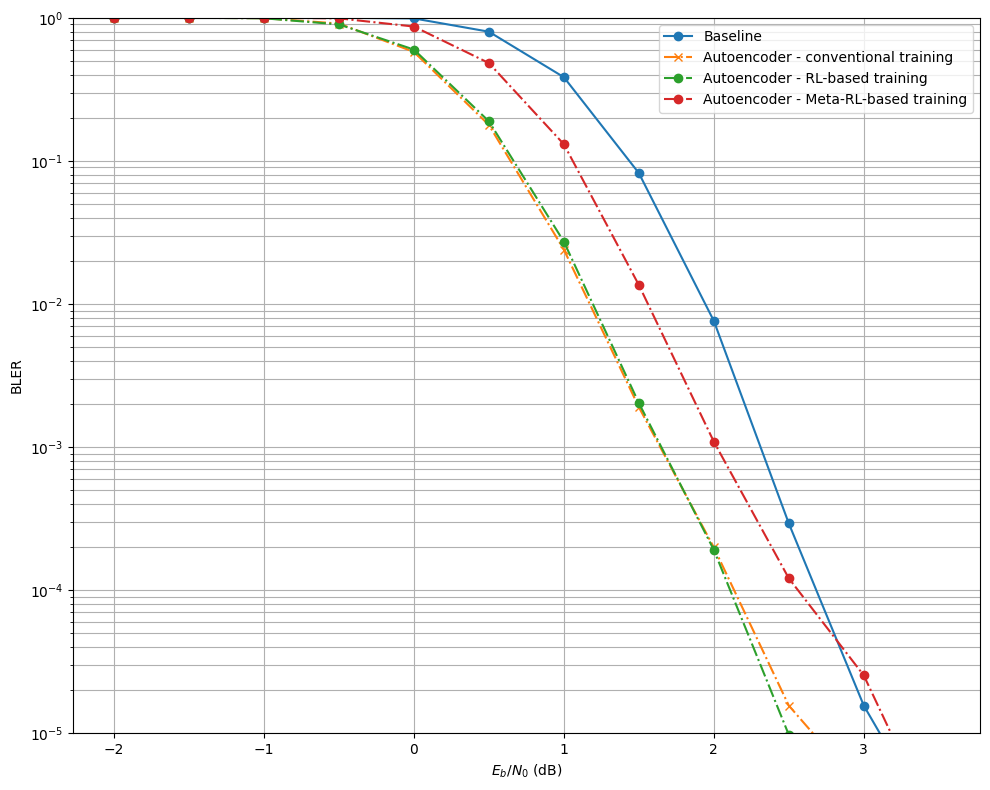

In [15]:
plt.figure(figsize=(10,8))
plt.semilogy(ebno_dbs, BLER['baseline'], 'o-', c=f'C0', label=f'Baseline')    
plt.semilogy(ebno_dbs, BLER['autoencoder-conv'], 'x-.', c=f'C1', label=f'Autoencoder - conventional training')
plt.semilogy(ebno_dbs, BLER['autoencoder-rl'], 'o-.', c=f'C2', label=f'Autoencoder - RL-based training')
plt.semilogy(ebno_dbs, BLER['autoencoder-metarl'], 'o-.', c=f'C3', label=f'Autoencoder - Meta-RL-based training')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-5, 1.0))
plt.legend()
plt.tight_layout()

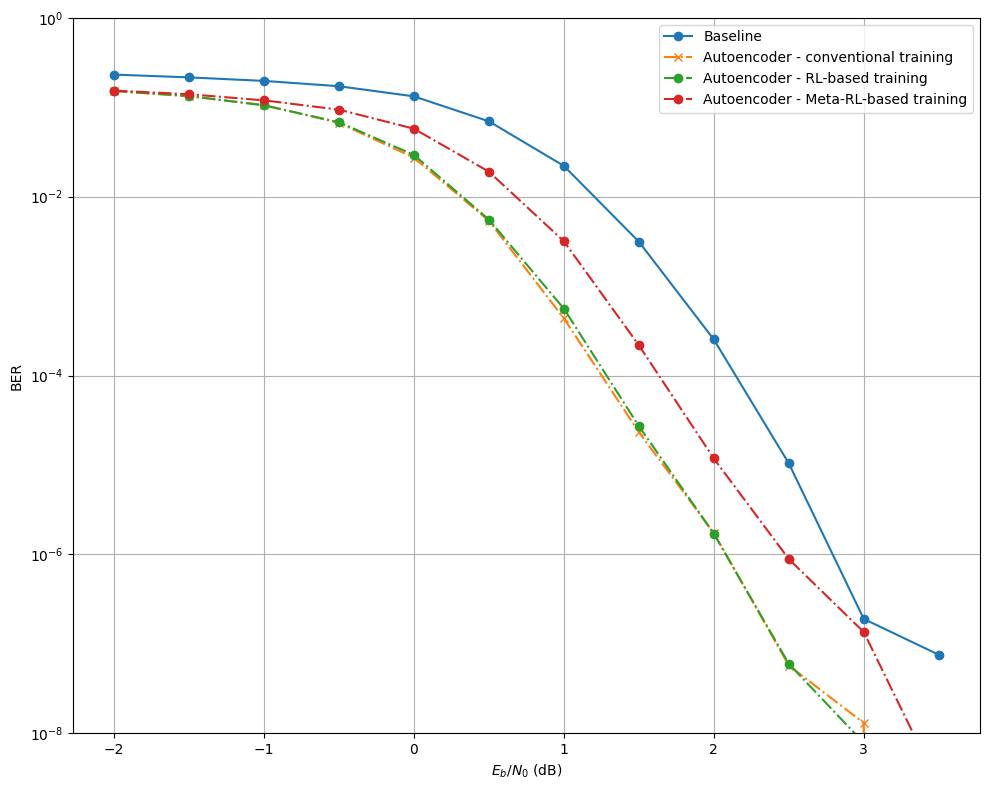

In [16]:
plt.figure(figsize=(10,8))
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', c=f'C0', label=f'Baseline')    
plt.semilogy(ebno_dbs, BER['autoencoder-conv'], 'x-.', c=f'C1', label=f'Autoencoder - conventional training')
plt.semilogy(ebno_dbs, BER['autoencoder-rl'], 'o-.', c=f'C2', label=f'Autoencoder - RL-based training')
plt.semilogy(ebno_dbs, BER['autoencoder-metarl'], 'o-.', c=f'C3', label=f'Autoencoder - Meta-RL-based training')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.ylim((1e-8, 1.0))
plt.legend()
plt.tight_layout()